<a href="https://www.kaggle.com/code/joeroberts/model-binary-1gram?scriptVersionId=112863623" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import StandardScaler

from transformers import BertTokenizer

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow import keras
from tensorflow.keras import layers

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

#sklearn processing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#configs
max_tokens = 20000

/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv
/kaggle/input/feedback-prize-english-language-learning/train.csv
/kaggle/input/feedback-prize-english-language-learning/test.csv


In [3]:
sample_submission_raw = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv')
train_data_raw = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/train.csv')
test_from_comp = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/test.csv')

In [4]:
train, test = train_test_split(train_data_raw, test_size=0.2, random_state=21) #20% for test
train, val = train_test_split(train, test_size=0.1, random_state=21) # 10% for validation
train

targets=['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

train_targets = train[targets]
val_targets = val[targets]
test_targets = test[targets]

train_targets_ds = tf.convert_to_tensor(train_targets)
val_targets_ds = tf.convert_to_tensor(val_targets)
test_targets_ds = tf.convert_to_tensor(test_targets)

train_text_only = tf.convert_to_tensor(train['full_text'])
val_text_only = tf.convert_to_tensor(val['full_text'])
test_text_only = tf.convert_to_tensor(test['full_text'])


## for submission 
all_train_targets = train_data_raw[targets]
all_train_targets_ds = tf.convert_to_tensor(all_train_targets)
all_train_text_only = tf.convert_to_tensor(train_data_raw['full_text'])

all_test_text_only = tf.convert_to_tensor(test_from_comp['full_text'])


2022-12-03 20:40:20.089901: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 20:40:20.186886: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 20:40:20.187688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 20:40:20.190915: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="multi_hot",
)

#use the dataset to index the dataset vocab via the adapt method
text_vectorization.adapt(train_text_only)

train_features_ds = text_vectorization(train_text_only)
val_features_ds = text_vectorization(val_text_only)
test_features_ds = text_vectorization(test_text_only)

#for submission
all_train_features_ds = text_vectorization(all_train_text_only)
all_test_features_ds = text_vectorization(all_test_text_only)


2022-12-03 20:40:31.896362: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [17]:
def get_model(max_tokens=max_tokens, hidden_dim=32):
    inputs = keras.Input(shape=(max_tokens,))

    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(rate=0.5)(x)
    
    x = layers.Dense(hidden_dim, activation="relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    
    x = layers.Dense(hidden_dim, activation="relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    

    outputs = layers.Dense(6, activation=None)(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="mean_absolute_error",
        metrics=[tf.keras.metrics.RootMeanSquaredError(
                name='root_mean_squared_error', dtype=None
            )]
    )
    return model

#train model and test
model = get_model()
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("binary_1gram.keras", save_best_only=True)
]
hist = model.fit(
    x=train_features_ds,
    y=train_targets_ds,
    validation_data = (
        val_features_ds, val_targets_ds
    ),
    epochs=30,
    callbacks=callbacks
)

model = keras.models.load_model("binary_1gram.keras")
print(f"Test acc: {model.evaluate(test_features_ds, test_targets_ds, 1)}")


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 20000)]           0         
_________________________________________________________________
dense_24 (Dense)             (None, 32)                640032    
_________________________________________________________________
dropout_18 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_19 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_20 (Dropout)         (None, 32)                0   

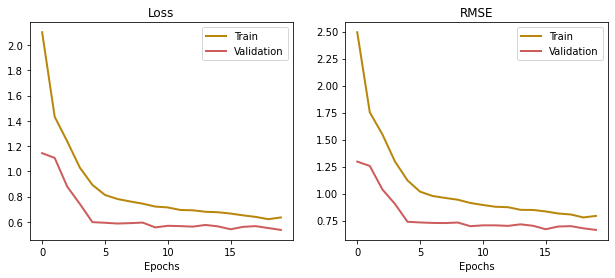

In [16]:
# grab history
history = hist.history

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)

plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.5,0.7)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

ax = fig.add_subplot(1, 3, 2)

plt.plot(history['root_mean_squared_error'], lw=2, color='darkgoldenrod')
plt.plot(history['val_root_mean_squared_error'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.5,0.7)
ax.set_xlabel('Epochs', size=10)
ax.set_title('RMSE');


In [19]:
#
model = get_model()
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("binary_1gram.keras", save_best_only=True)
]
hist = model.fit(
    x=all_train_features_ds,
    y=all_train_targets_ds,
    validation_data = None,
    epochs=25,
    callbacks=callbacks
)

# model = keras.models.load_model("binary_1gram.keras")

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 20000)]           0         
_________________________________________________________________
dense_32 (Dense)             (None, 32)                640032    
_________________________________________________________________
dropout_24 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_25 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_26 (Dropout)         (None, 32)                0   

## Submission to contest

In [21]:
test_predictions = model.predict(all_test_features_ds)
test_predictions = pd.DataFrame(test_predictions)

test_from_comp['cohesion'] = test_predictions[0]
test_from_comp['syntax'] = test_predictions[1]
test_from_comp['vocabulary'] = test_predictions[2]
test_from_comp['phraseology'] = test_predictions[3]
test_from_comp['grammar'] = test_predictions[4]
test_from_comp['conventions'] = test_predictions[5]
test_from_comp

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,when a person has no experience on a job their...,2.758988,2.684069,2.878167,2.755014,2.664553,2.717772
1,000BAD50D026,Do you think students would benefit from being...,2.910730,2.832052,3.018367,2.904160,2.817423,2.865193
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde...",3.061314,2.973727,3.167066,3.058733,2.969204,3.010985


In [22]:
res = test_from_comp.drop("full_text",axis=1)
res.to_csv("/kaggle/working/submission.csv",index=False)